In [1]:
import pybamm as pb
import pybammeis
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [16]:
# Define all our parameters

# OCV curves for the anode and cathode
# Simple math model for the individual electrode potentials as a function of the stoichiometry of Lithium
def MJ1_ocp_tanh_SiC(sto):
    x = sto
    p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
    
    return (
            p[0] * pb.exp(-p[1] * x)
            + p[2]
            - p[3] * pb.tanh(p[4] * (x - p[5]))
            - p[6] * pb.tanh(p[7] * (x - p[8]))
            - p[9] * pb.tanh(p[10] * (x - p[11]))
        )

def MJ1_ocp_tanh_NMC(sto):
    x = sto
    p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])

    return (
            -p[0] * x
            + p[1]
            - p[2] * pb.tanh(p[3] * (x - p[4]))
            - p[5] * pb.tanh(p[6] * (x - p[7]))
            + p[8] * pb.tanh(p[9] * (x - p[10]))
        )

# Parameters from literature
literature_params = {
    'Electrode height [m]': 0.059,
    'Electrode width [m]': 0.610*2, # Multiplying by two since the electrode has active material on both sides.
    'Lower voltage cut-off [V]': 2.5,
    'Upper voltage cut-off [V]': 4.5,
    'Nominal cell capacity [A.h]': 3.5,

    # From Table 3 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Maximum concentration in negative electrode [mol.m-3]': 32418.5,
    'Negative particle radius [m]': 6.1e-06,
    'Negative electrode porosity': 0.216,
    'Negative electrode active material volume fraction': 0.7011854763922494,
    'Negative electrode conductivity [S.m-1]': 100.0,
    'Negative electrode diffusivity [m2.s-1]': 5e-14,
    'Negative electrode OCP [V]': MJ1_ocp_tanh_SiC,

    # 'Maximum concentration in positive electrode [mol.m-3]': 51081.15,
    'Positive particle radius [m]': 3.8e-06,
    'Positive electrode porosity': 0.171,
    'Positive electrode active material volume fraction': 0.7355902286855152,
    'Positive electrode conductivity [S.m-1]': 0.17,
    'Positive electrode diffusivity [m2.s-1]': 5e-13,
    'Positive electrode OCP [V]': MJ1_ocp_tanh_NMC,

    'Separator porosity': 0.45,

    # end of section 3 data
    
    # From Table A-9 and A-10 in https://doi.org/10.1016/j.jpowsour.2018.11.043
    'Negative current collector conductivity [S.m-1]': 5.9e7/(1+3.383e-3 * (298.15-293.15)), 
    'Negative current collector thickness [m]': 11e-06,
    'Negative current collector density [kg.m-3]': 8950.0,
    'Negative current collector specific heat capacity [J.kg-1.K-1]': 385.0,
    'Negative current collector thermal conductivity [W.m-1.K-1]': 398.0,
    'Negative electrode density [kg.m-3]': 2242.0,
    'Negative electrode specific heat capacity [J.kg-1.K-1]': 867.0,
    'Negative electrode thermal conductivity [W.m-1.K-1]': 1.04,
    'Negative electrode thickness [m]': 86.7e-6, # 86.7 in Sturm 2019, 85um in Heenan2020, 170um in NASA
    'Positive current collector conductivity [S.m-1]': 3.78e7/(1+4.290e-3 * (298.15-293.15)),
    'Positive current collector density [kg.m-3]': 2710.0,
    'Positive current collector specific heat capacity [J.kg-1.K-1]': 903.0,
    'Positive current collector thermal conductivity [W.m-1.K-1]': 238.0,
    'Positive current collector thickness [m]': 17.3e-06,
    'Positive electrode density [kg.m-3]': 4870.0,
    'Positive electrode specific heat capacity [J.kg-1.K-1]': 840.1,
    'Positive electrode thermal conductivity [W.m-1.K-1]': 1.58,
    'Positive electrode thickness [m]': 66.2e-6, #66.2um in Sturm2019, 72.5um in Heenan2020, 160um in NASA
    'Separator density [kg.m-3]': 1009.0,
    'Separator specific heat capacity [J.kg-1.K-1]': 1978.2,
    'Separator thermal conductivity [W.m-1.K-1]': 0.33,
    'Separator thickness [m]': 12e-06,
    # end of table data
    "Current function [A]": 0.7
    }

# Use default parameters from the Chen2020 publication
params = pb.ParameterValues("Chen2020")

# Overwrite parameters with our own
for parameter, value in literature_params.items():
    try:
        if params[parameter] != value:
            params[parameter] = value
    except KeyError as e:
        print(f"Parameter {parameter} not part of default. Skipping.")

print(MJ1_ocp_tanh_SiC(0.7))
print(MJ1_ocp_tanh_NMC(0.3))


0.07628046503418406
4.181216140666922


In [3]:
# Initialize model using PyBaMM defaults
model = pb.lithium_ion.DFN()

# Define experiment
experiment = pb.Experiment([
    ("Rest for 1 minutes"),
    ("Discharge at C/5 for 12 hours or until 3.0 V"),
])

In [4]:
# Simulate the experiment using the model with the custom parameter set
sim = pb.Simulation(model,  parameter_values=params, experiment=experiment) # , 

safe_solver = pb.CasadiSolver(mode="fast", return_solution_if_failed_early=True)

output = sim.solve(solver=safe_solver, calc_esoh=False)

In [5]:
output.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=4.9324543695560115, step=0.04932454369556011…

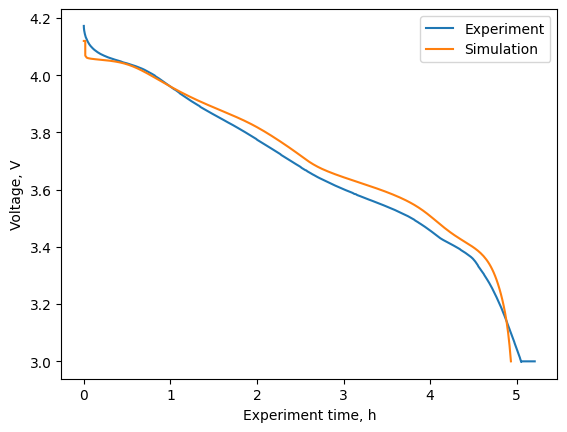

In [6]:
# Load experimental data & select relevant discharge
exp_bench = pd.read_csv("/Users/synnemard/Desktop/lithium_ion/MJ1_01_01.csv")
#exp_bench = pd.read_csv("MJ1_01_01.csv")
exp_bench["t"] = exp_bench["t"] - exp_bench["t"].iloc[0]
exp_bench = exp_bench[exp_bench["t"] < 12*3600]
exp_bench = exp_bench[exp_bench["t"] > 2*3600]
exp_bench = exp_bench[exp_bench["I"]<0] # Remove charge cycle
exp_bench["t"] = exp_bench["t"] - exp_bench["t"].iloc[0]


plt.plot(exp_bench["t"]/3600, exp_bench["U1"], label="Experiment")
plt.plot(sim.solution['Time [s]'].entries/3600, sim.solution['Voltage [V]'].entries, label="Simulation")
plt.xlabel("Experiment time, h")
plt.ylabel("Voltage, V")
plt.legend()


Comparing impedance from direct extraction and simulated AC current

In [7]:
# First, plotting the current (want the amplitude A to be 1 - 10% of this value)

output_var = ["Current [A]"]
output.plot(output_variables = output_var)

# (Could also define I as the output current, and then A as the amplitude): 

I = output["Current [A]"]
# Choosing the sinus amplitude to be 10% of this. 
A = I.entries[2]*0.1
print(A)

interactive(children=(FloatSlider(value=0.0, description='t', max=4.9324543695560115, step=0.04932454369556011…

0.07


In [8]:

# Secondly, simulating an AC current 

model_eis = pb.lithium_ion.DFN(options={"surface form": "differential"}) #denne option har noe å si 

import numpy as np
def my_current(t):
    return A*pb.sin(np.pi*t/4)

params["Current function [A]"] = my_current

sim_AC = pb.Simulation(model_eis, parameter_values=params)
t_eval = np.linspace(0, 11)
sim_AC.solve(t_eval=t_eval)
sim_AC.plot(["Current [A]"]) 

eis_AC = pybammeis.EISSimulation(model_eis, parameter_values=params)
sol_AC = eis_AC.solve(np.logspace(-4, 4, 30))



interactive(children=(FloatSlider(value=0.0, description='t', max=11.0, step=0.11), Output()), _dom_classes=('…

In [9]:
#Simulate impedance from direct extraction 

params["Current function [A]"] = 0.7

eis_extract = pybammeis.EISSimulation(model, parameter_values=params)
# calculate impedance at log-spaced frequencies
sol_extract = eis_extract.solve(np.logspace(-4, 4, 30))

sim_extract = pb.Simulation(model, parameter_values=params)
sim_extract = sim.solve(solver=safe_solver, calc_esoh=False)
sim_extract.plot(["Current [A]"]) 

interactive(children=(FloatSlider(value=0.0, description='t', max=4.9324543695560115, step=0.04932454369556011…

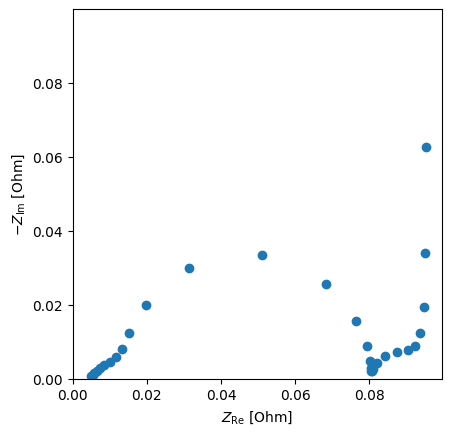

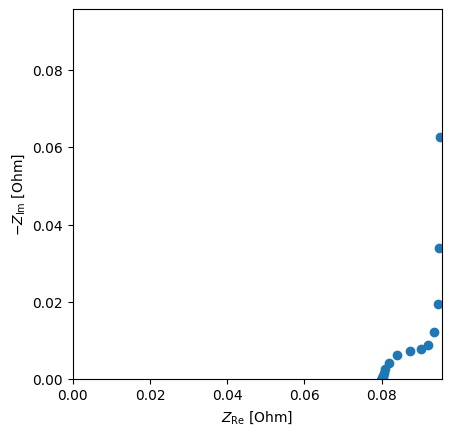

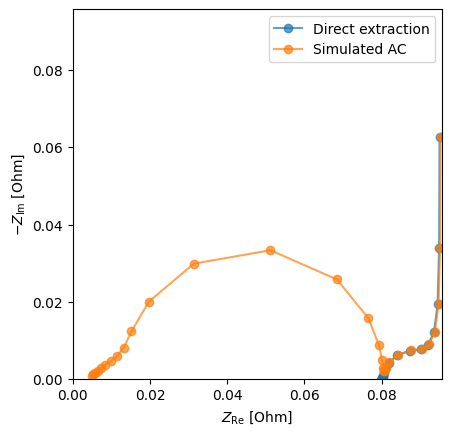

In [10]:
#Compare the two methods 

models = [model, model_eis] #models (Amund's and Pybammeis' tutorial)
solutions = [sol_extract, sol_AC] #impedances
names = ["Direct extraction", "Simulated AC"]


eis_AC.nyquist_plot()
eis_extract.nyquist_plot()

_, ax = plt.subplots()
for i, model in enumerate(models):
    ax = pybammeis.nyquist_plot(solutions[i], ax=ax, linestyle="-", label=f"{names[i]}", alpha=0.7
    )
ax.legend()
plt.show()


Comments: 
- My direct extraction does not match Amund's direct extraction, even though I used the parameters I got from Amund? The only change is that I defined a new input parameter "Current function [A]" with the same value as the output current in Amund's model so that I could further change the parameter. 

- The option: "surface form": "differential", for some reason adds the semicircle to the plot? 